<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

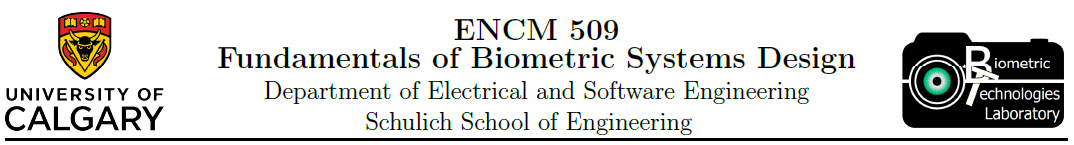

# Lab 7

## Introduction

The purpose of this lab exercise is to apply the concepts of machine learning to recognize gestures performed by a
hand, such as circle and swipe in the air, based on the coordinates of the hands’ joints identified by the Leap Motion
device.

In [103]:

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from utils_cm import plot_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

#import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join, dirname, abspath

In [104]:
# the length of records (if shorter, we need to add some zero rows)
NUMBER_TIMESTEPS = 100
# the number of features (from the data)
NUMBER_FEATURES = 202
# the number of classes/gestures
NUMBER_OUTPUTS = 2
# you can encode more than 1 but for this example we have binary output (circle/swipe)

In [105]:
# the directory where your data is
mypath = './data'

# creating a list with all the filenames
datafiles = [f for f in listdir('data') if isfile(join(mypath, f))]

In [106]:
# choose data we need
columns = ['handPalmPosition_X','handPalmPosition_Y','handPalmPosition_Z',
          'pitch', 'roll', 'yaw', 'GestureTypeCircle', 'GestureTypeSwipe',
          'wristPosition_X', 'wristPosition_Y','wristPosition_Z',
          'elbowPosition_X', 'elbowPosition_Y', 'elbowPosition_Z']

finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
bone_names = ['Metacarpal', 'Proximal', 'Intermediate', 'Distal']
    
for finger in finger_names:
    columns.append(finger + 'Length')
    columns.append(finger + 'Width')

for finger in finger_names:
    for bone in bone_names:
        columns.append(finger + bone + 'Start_X')
        columns.append(finger + bone + 'Start_Y')
        columns.append(finger + bone + 'Start_Z')
        columns.append(finger + bone + 'End_X')
        columns.append(finger + bone + 'End_Y')
        columns.append(finger + bone + 'End_Z')
        columns.append(finger + bone + 'Direction_X') 
        columns.append(finger + bone + 'Direction_Y') 
        columns.append(finger + bone + 'Direction_Z')   

In [107]:
# Features
x = []
# Labels
y = []

for sample in datafiles:
    relative_path = 'data/' + sample
    tmp = pd.read_csv(relative_path, usecols=columns)
    
    # Normalize the sample size: LSTM requires all inputs of the same size!
    print('{}\nsize raw = {}'.format(relative_path,tmp.shape))
    while tmp.shape[0] < NUMBER_TIMESTEPS:
        tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)

    if tmp.shape[0] > NUMBER_TIMESTEPS:
        tmp = tmp.head(100)
    print('size normalized = ',tmp.shape)
    
    tmp_x = tmp[[column for column in list(tmp.columns)
                 if column != 'GestureTypeCircle' 
                 and column != 'GestureTypeSwipe']]
    tmp_y = tmp[['GestureTypeCircle', 'GestureTypeSwipe']]
        
    x.append(tmp_x)
    y.append(tmp_y)

data/circle10.csv
size raw = (60, 204)
size normalized =  (100, 204)
data/swipe9.csv
size raw = (99, 204)
size normalized =  (100, 204)
data/swipe8.csv
size raw = (51, 204)
size normalized =  (100, 204)
data/swipe10.csv
size raw = (84, 204)
size normalized =  (100, 204)
data/circle8.csv
size raw = (97, 204)
size normalized =  (100, 204)
data/circle9.csv
size raw = (67, 204)
size normalized =  (100, 204)
data/circle4.csv
size raw = (39, 204)
size normalized =  (100, 204)
data/circle5.csv
size raw = (78, 204)
size normalized =  (100, 204)
data/circle7.csv
size raw = (80, 204)
size normalized =  (100, 204)
data/circle6.csv
size raw = (129, 204)
size normalized =  (100, 204)
data/circle2.csv
size raw = (66, 204)
size normalized =  (100, 204)
data/circle3.csv
size raw = (39, 204)
size normalized =  (100, 204)
data/circle1.csv
size raw = (37, 204)
size normalized =  (100, 204)
data/swipe5.csv
size raw = (47, 204)
size normalized =  (100, 204)
data/swipe4.csv
size raw = (59, 204)
size normali

In [108]:
np.array(y[0].loc[0])

array([1, 0])

In [109]:
# Each sample requires labels of [1,NUMBER_OUTPUTS] size (not a list)
y_new = list()
for cur_label in y:
    tmp = np.array(cur_label.loc[0])
    y_new.append(tmp)
y = np.array(y_new)
#print(y)

In [110]:
def build_model():
    model = models.Sequential()    
    # an input layer that expects:
    # 1 or more samples, NUMBER_TIMESTEPS time steps and NUMBER_FEATURES features.
    
    # 1st LSTM layer
    model.add(layers.LSTM(256, return_sequences=True, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    
    # 2nd LSTM layer
    model.add(layers.LSTM(256, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    
    # Hidden fully connected layers of the neural network
    model.add(layers.Dense(512,activation='relu'))  
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256,activation='relu'))    
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512,activation='relu'))
    
    # Classification layer of the neural network
    model.add(layers.Dense(NUMBER_OUTPUTS, activation='softmax'))
    
    opt = Adam(learning_rate=0.002)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # this shows the network structure 
    model.summary()
    
    return model

In [111]:
def build_model2():
    model = models.Sequential()    
    # an input layer that expects:
    # 1 or more samples, NUMBER_TIMESTEPS time steps and NUMBER_FEATURES features.
    
    # 1st LSTM layer
    model.add(layers.LSTM(256, return_sequences=True, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    
    # 2nd LSTM layer
    model.add(layers.LSTM(256, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )

    
    # Hidden fully connected layers of the neural network
    model.add(layers.Dense(512,activation='relu'))  
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256,activation='relu'))    
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512,activation='relu'))
    model.add(layers.Dense(256,activation='relu'))    
    model.add(layers.Dropout(0.5))

    
    # Classification layer of the neural network
    model.add(layers.Dense(NUMBER_OUTPUTS, activation='softmax'))
    
    opt = Adam(learning_rate=0.002)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # this shows the network structure 
    model.summary()
    
    return model

In [112]:
def build_model3():
    model = models.Sequential()    
    # an input layer that expects:
    # 1 or more samples, NUMBER_TIMESTEPS time steps and NUMBER_FEATURES features.
    
    # 1st LSTM layer
    model.add(layers.LSTM(256, return_sequences=True, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    
    # 2nd LSTM layer
    model.add(layers.LSTM(256, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    
    # Hidden fully connected layers of the neural network
    model.add(layers.Dense(512,activation='relu'))  
    model.add(layers.Dropout(0.6))
    model.add(layers.Dense(256,activation='relu'))    
    model.add(layers.Dropout(0.6))
    model.add(layers.Dense(512,activation='relu'))
    
    # Classification layer of the neural network
    model.add(layers.Dense(NUMBER_OUTPUTS, activation='softmax'))
    
    opt = Adam(learning_rate=0.002)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # this shows the network structure 
    model.summary()
    
    return model

## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
1. Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section). (10 marks)
1. Conclusion (a paragraph on what is the main take-out of the lab).

For the following exercises, use the sample data available on D2L, or your own data.

- **Exercise** 1 (4 marks): Consider 60% of samples per gesture for training and 40% for testing. Perform the classier evaluation for this case. Next, use 80% of samples per gesture for training and 20% for testing. Perform the classier evaluation and compare it against the first case (60 and 40%).

In [113]:
# Set a percentage of test set fraction
test_size = 0.40 # 40%
train_size = 0.60 # 60%



# Divide data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, train_size=train_size, shuffle=True)
len_train = len(X_train)
len_test = len(X_test)

print ('Number of train samples = {}\nNumber of test samples = {}'.format(len_train, len_test))
print ('There is ',type(X_train),' of ',type(X_train[0]))

# Turn list(DataFrame) into numpy.ndarray with [len_train, NUMBER_TIMESTEPS, NUMBER_FEATURES]
X_train = np.array(X_train)
X_test = np.array(X_test)
print('The list was turned into <numpy.ndarray>')

Number of train samples = 12
Number of test samples = 8
There is  <class 'list'>  of  <class 'pandas.core.frame.DataFrame'>
The list was turned into <numpy.ndarray>


#### Build model

In [114]:
# creating the model
model = build_model()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 100, 256)          470016    
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_33 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 512)              

#### Train model

In [115]:
# training the model
model.fit(X_train, y_train, epochs=10, batch_size=len_train)

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.6933 - accuracy: 0.9167
Epoch 2/10
1/1 [==============================] - 0s 485ms/step - loss: 0.6798 - accuracy: 0.6667
Epoch 3/10
1/1 [==============================] - 0s 479ms/step - loss: 0.6385 - accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 498ms/step - loss: 0.5963 - accuracy: 0.6667
Epoch 5/10
1/1 [==============================] - 1s 503ms/step - loss: 0.4632 - accuracy: 0.7500
Epoch 6/10
1/1 [==============================] - 1s 505ms/step - loss: 0.1968 - accuracy: 0.9167
Epoch 7/10
1/1 [==============================] - 1s 512ms/step - loss: 0.0093 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 1s 516ms/step - loss: 1.7089e-04 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 494ms/step - loss: 2.6850e-05 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 477ms/step - loss: 1.1921e-07 - accuracy: 1.0000


#### Test model

In [116]:
# testing the model
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=len_train)

1/1 [==============================] - 1s 932ms/step - loss: 2.7504 - accuracy: 0.8750


In [117]:
y_pred = model.predict(X_test)

In [118]:
matches = (y_pred == y_test)
print('Total of matches: %d' % (matches.sum()))

match_rate = matches.sum() / float(len(matches))
print('Match rate: %.2f' % (match_rate))

Total of matches: 7
Match rate: 0.88


#### Create confusion matrix

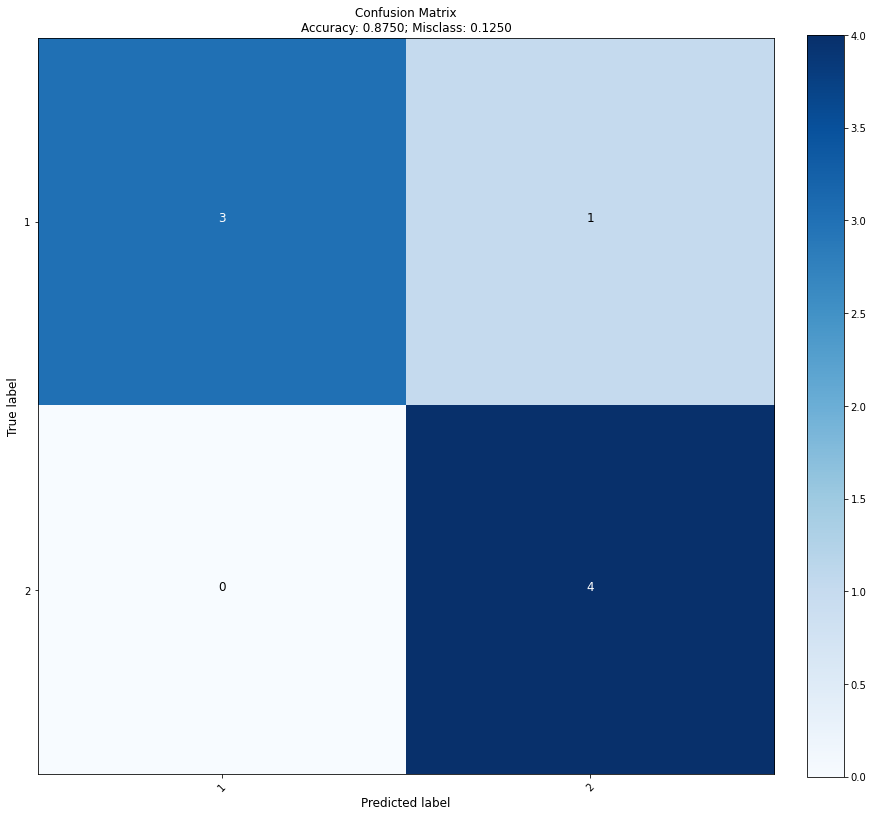

In [120]:
#confusionMatrix = multilabel_confusion_matrix(y_test, y_pred)

#print(confusionMatrix)

confusionMatrix =confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, NUMBER_OUTPUTS+1)])

#### Train 80% test 20%

In [121]:
# Set a percentage of test set fraction
test_size = 0.20 # 20%
train_size = 0.80 # 80%



# Divide data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, train_size=train_size, shuffle=True)
len_train = len(X_train)
len_test = len(X_test)

print ('Number of train samples = {}\nNumber of test samples = {}'.format(len_train, len_test))
print ('There is ',type(X_train),' of ',type(X_train[0]))

# Turn list(DataFrame) into numpy.ndarray with [len_train, NUMBER_TIMESTEPS, NUMBER_FEATURES]
X_train = np.array(X_train)
X_test = np.array(X_test)
print('The list was turned into <numpy.ndarray>')

Number of train samples = 16
Number of test samples = 4
There is  <class 'list'>  of  <class 'pandas.core.frame.DataFrame'>
The list was turned into <numpy.ndarray>


#### Build model

In [122]:
# creating the model
model = build_model()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 100, 256)          470016    
_________________________________________________________________
lstm_19 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_37 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)              

#### Train model

In [123]:
# training the model
model.fit(X_train, y_train, epochs=10, batch_size=len_train)

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.6780 - accuracy: 0.5625
Epoch 2/10
1/1 [==============================] - 1s 512ms/step - loss: 0.6578 - accuracy: 0.5625
Epoch 3/10
1/1 [==============================] - 1s 531ms/step - loss: 0.6219 - accuracy: 0.6875
Epoch 4/10
1/1 [==============================] - 1s 541ms/step - loss: 0.4889 - accuracy: 0.7500
Epoch 5/10
1/1 [==============================] - 1s 595ms/step - loss: 0.3882 - accuracy: 0.7500
Epoch 6/10
1/1 [==============================] - 1s 616ms/step - loss: 0.1734 - accuracy: 0.9375
Epoch 7/10
1/1 [==============================] - 1s 595ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 1s 506ms/step - loss: 2.3139e-05 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 494ms/step - loss: 1.5392 - accuracy: 0.8750
Epoch 10/10
1/1 [==============================] - 0s 490ms/step - loss: 3.9152e-04 - accuracy: 1.0000


#### Test Model

In [124]:
# testing the model
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=len_train)

1/1 [==============================] - 1s 1s/step - loss: 7.9113 - accuracy: 0.7500


In [125]:
y_pred = model.predict(X_test)

In [126]:
matches = (y_pred == y_test)
print('Total of matches: %d' % (matches.sum()))

match_rate = matches.sum() / float(len(matches))
print('Match rate: %.2f' % (match_rate))

Total of matches: 1
Match rate: 0.25


#### Create confusion matrix

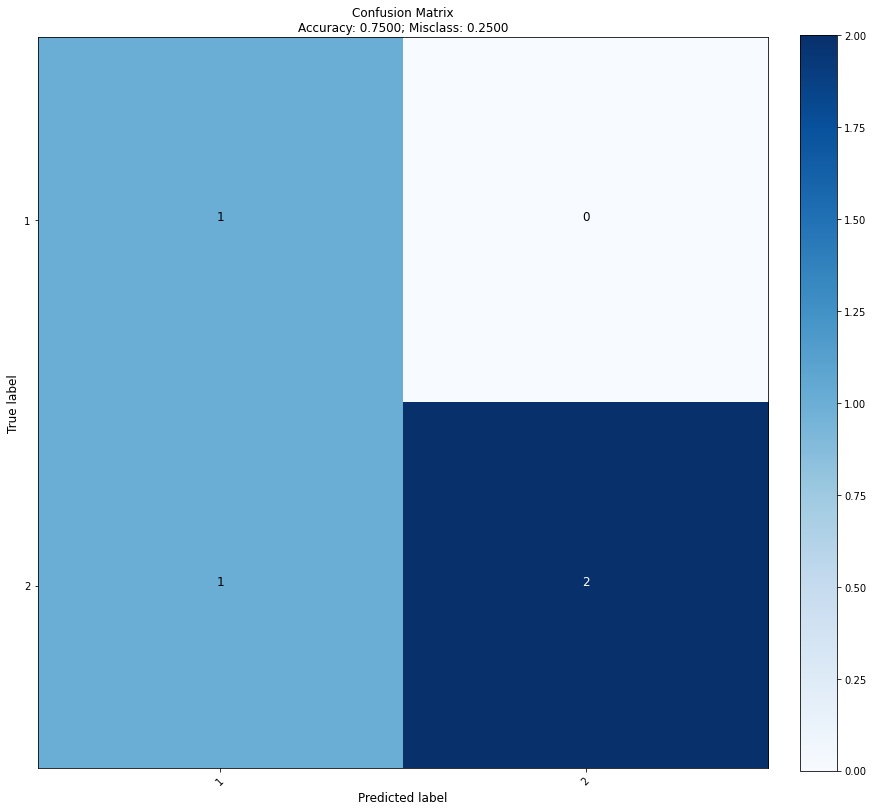

In [127]:
#confusionMatrix = multilabel_confusion_matrix(y_test, y_pred)

#print(confusionMatrix)

confusionMatrix =confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, NUMBER_OUTPUTS+1)])

#### Comparison

| Train size   |  TP  |  TN |      FP      |  FN | Accuracy | Misclass
|----------|--------|------|------|------|------|------|
| 0.6 |  3 | 4 | 1 | 0 | 0.875 | 0.125
| 0.8 |  2 | 2 | 0 | 0 | 0.75 | 0.25


From the observations we can tell that the model with 60 percent train size is more accurate


- **Exercise 2** (3 marks): Consider two different numbers of the LSTM layers. Perform the classifier evaluation and compare your two choices of the layers' numbers.

In [128]:
# Set a percentage of test set fraction
test_size = 0.40 # 40%
train_size = 0.60 # 60%



# Divide data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, train_size=train_size, shuffle=True)
len_train = len(X_train)
len_test = len(X_test)

print ('Number of train samples = {}\nNumber of test samples = {}'.format(len_train, len_test))
print ('There is ',type(X_train),' of ',type(X_train[0]))

# Turn list(DataFrame) into numpy.ndarray with [len_train, NUMBER_TIMESTEPS, NUMBER_FEATURES]
X_train = np.array(X_train)
X_test = np.array(X_test)
print('The list was turned into <numpy.ndarray>')


Number of train samples = 12
Number of test samples = 8
There is  <class 'list'>  of  <class 'pandas.core.frame.DataFrame'>
The list was turned into <numpy.ndarray>


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 100, 256)          470016    
_________________________________________________________________
lstm_21 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_41 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 512)             

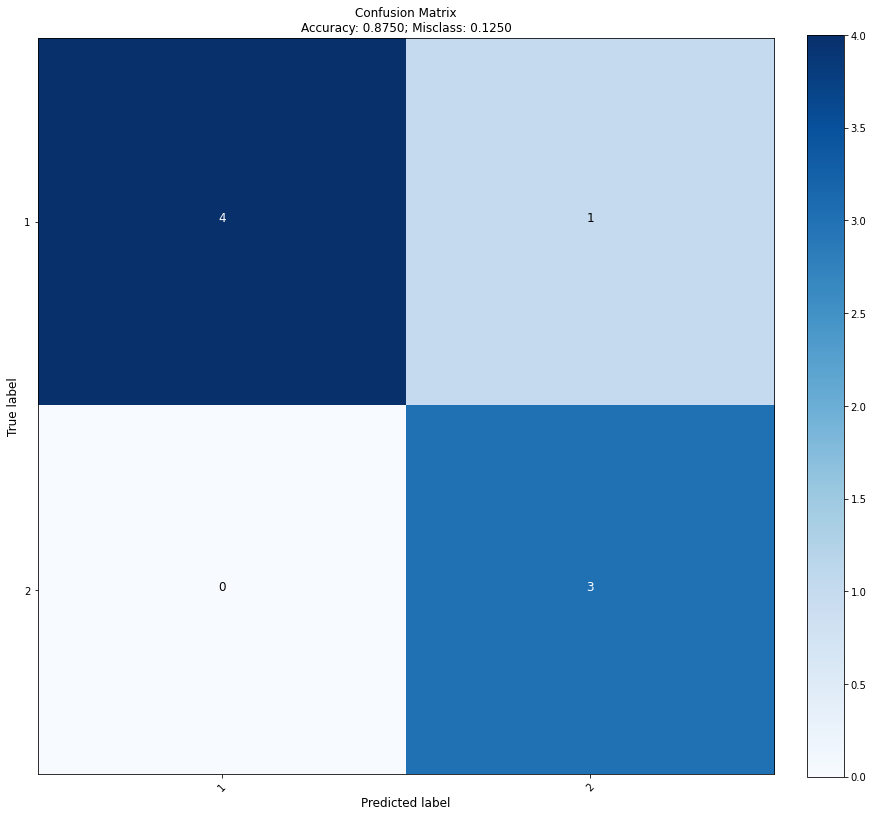

In [129]:
# creating the model
model2 = build_model2()

# training the model
model2.fit(X_train, y_train, epochs=10, batch_size=len_train)

# testing the model
test_loss, test_acc = model2.evaluate(X_test, y_test, batch_size=len_train)

y_pred = model2.predict(X_test)

matches = (y_pred == y_test)
print('Total of matches: %d' % (matches.sum()))

match_rate = matches.sum() / float(len(matches))
print('Match rate: %.2f' % (match_rate))

#confusionMatrix = multilabel_confusion_matrix(y_test, y_pred)

#print(confusionMatrix)

confusionMatrix =confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, NUMBER_OUTPUTS+1)])

#### Conclusion

| LSTM Layers   |  TP  |  TN |      FP      |  FN | Accuracy | Misclass
|----------|--------|------|------|------|------|------|
| 8 |  3 | 4 | 1 | 0 | 0.875 | 0.125
| 10 |  4 | 3 | 1 | 0 | 0.875 | 0.125


From the observations we can tell that the both models give similar results with slight difference in number of true positives and true negatives.



- **Exercise 3** (3 marks): Consider the dropout probability. In the code, it is set to 0.5. Change it to another value. Perform the classifier evaluation and compare it against the first case (60 and 40%).

In [130]:
# Set a percentage of test set fraction
test_size = 0.40 # 40%
train_size = 0.60 # 60%



# Divide data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, train_size=train_size, shuffle=True)
len_train = len(X_train)
len_test = len(X_test)

print ('Number of train samples = {}\nNumber of test samples = {}'.format(len_train, len_test))
print ('There is ',type(X_train),' of ',type(X_train[0]))

# Turn list(DataFrame) into numpy.ndarray with [len_train, NUMBER_TIMESTEPS, NUMBER_FEATURES]
X_train = np.array(X_train)
X_test = np.array(X_test)
print('The list was turned into <numpy.ndarray>')



Number of train samples = 12
Number of test samples = 8
There is  <class 'list'>  of  <class 'pandas.core.frame.DataFrame'>
The list was turned into <numpy.ndarray>


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 100, 256)          470016    
_________________________________________________________________
lstm_23 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_46 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 512)             

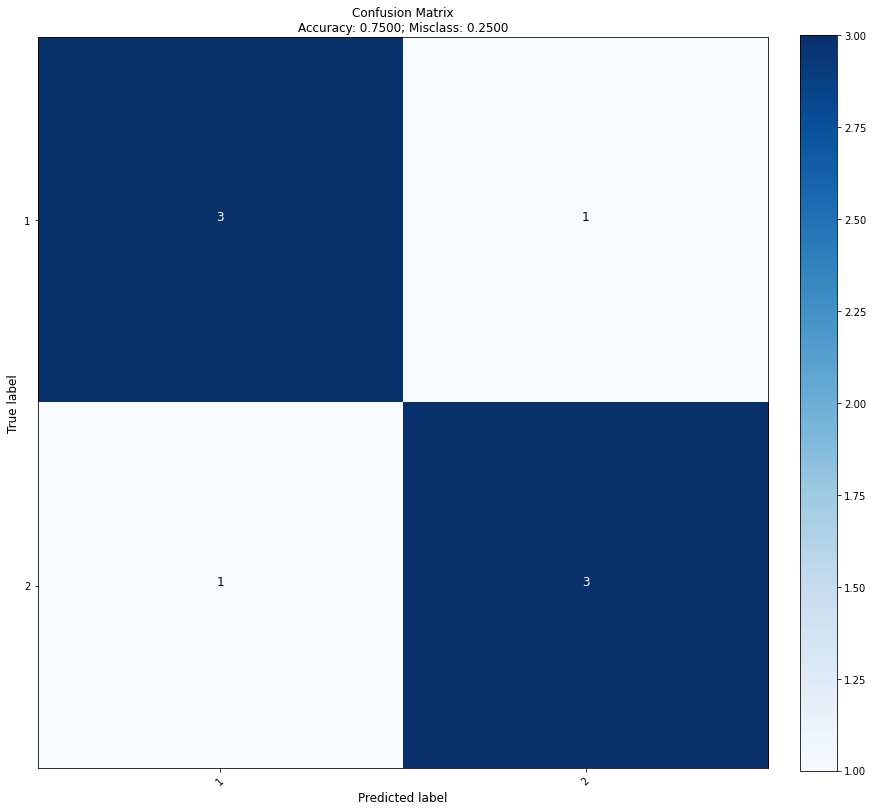

In [131]:
# creating the model
model3 = build_model3()

# training the model
model3.fit(X_train, y_train, epochs=10, batch_size=len_train)

# testing the model
test_loss, test_acc = model3.evaluate(X_test, y_test, batch_size=len_train)

y_pred = model3.predict(X_test)

matches = (y_pred == y_test)
print('Total of matches: %d' % (matches.sum()))

match_rate = matches.sum() / float(len(matches))
print('Match rate: %.2f' % (match_rate))

#confusionMatrix = multilabel_confusion_matrix(y_test, y_pred)

#print(confusionMatrix)

confusionMatrix =confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, NUMBER_OUTPUTS+1)])

#### Conclusion

| Dropout probability   |  TP  |  TN |      FP      |  FN | Accuracy | Misclass
|----------|--------|------|------|------|------|------|
| 0.5 |  3 | 4 | 1 | 0 | 0.875 | 0.125
| 0.6 |  3 | 3 | 1 | 1 | 0.75 | 0.25


From the observations we can tell that the second model with more dropout probability of 0.6 has less accuracy. 


